<a href="https://colab.research.google.com/github/arjunjanamatti/finance_and_trading/blob/master/lstm_futures_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#for deep learning model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

### Strategy#1
* Here only the nextprice is predicted

Train size:  (196000, 5)
Test size: (4000, 5)
X_train size:  (195988, 12, 5)
y_train size: (195988, 1)
Epoch 1/30
307/307 [==============================] - 24s 77ms/step - loss: 0.0154
Epoch 2/30
307/307 [==============================] - 23s 74ms/step - loss: 0.0045
Epoch 3/30
307/307 [==============================] - 23s 75ms/step - loss: 0.0037
Epoch 4/30
307/307 [==============================] - 23s 75ms/step - loss: 0.0029
Epoch 5/30
307/307 [==============================] - 23s 74ms/step - loss: 0.0022
Epoch 6/30
307/307 [==============================] - 23s 76ms/step - loss: 0.0017
Epoch 7/30
307/307 [==============================] - 23s 75ms/step - loss: 0.0013
Epoch 8/30
307/307 [==============================] - 23s 75ms/step - loss: 9.7316e-04
Epoch 9/30
307/307 [==============================] - 23s 75ms/step - loss: 7.8017e-04
Epoch 10/30
307/307 [==============================] - 23s 75ms/step - loss: 6.6496e-04
Epoch 11/30
307/307 [==============================] -

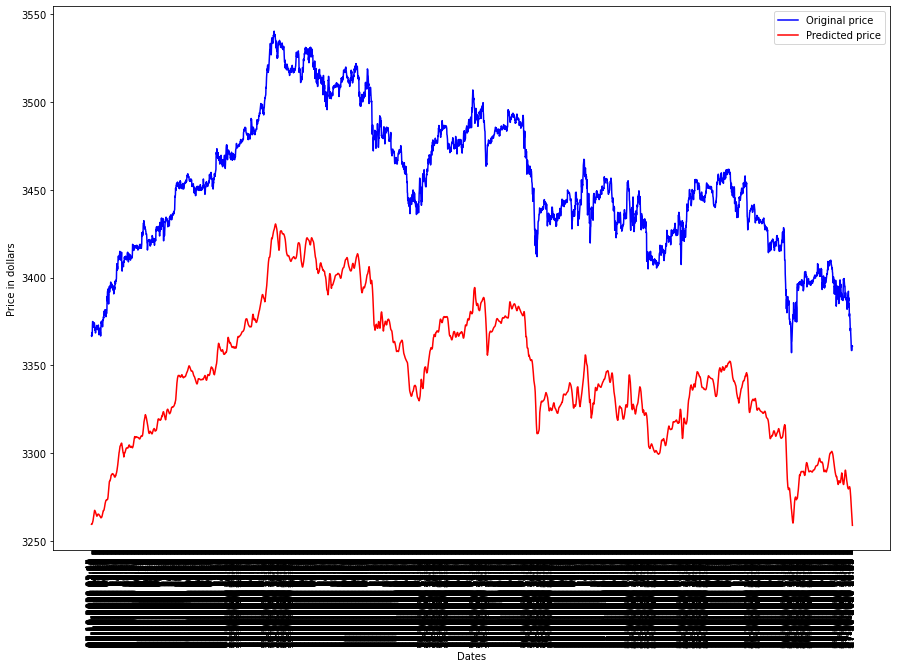

In [2]:
# load the dataframe
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/lstm_stocks/excel_data.txt', delimiter  = '\t')
df = df.set_index('Date Time')
df.columns = ['open', 'high', 'low', 'last', 'volume', 'num_of_trades']
df = df.drop(labels = 'num_of_trades', axis = 1)

# reverse such that latest dates are in the last
df = df[::-1]

# split to training and testing data
train_set = df[:int(len(df)*0.98)].values
test_set = df[int(len(df)*0.98):].values
print("Train size: ",train_set.shape)
print("Test size:",test_set.shape)

# scaling the data
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)

# arrange data for X_train and y_train
# number_of_values is the number of time frame used as X_train for y_train
number_of_values = 12
X_train, y_train = [], []
column = 0
for i in range(number_of_values, len(train_set)):
  X_train.append(train_set[i-number_of_values:i])
  #here we will predict the open price, hence column = 0
  y_train.append(train_set[i, column])
X_train, y_train = np.array(X_train), np.array(y_train)
y_train = np.reshape(y_train, (-1,1))
print("X_train size: ",X_train.shape)
print("y_train size:",y_train.shape)

# neural LSTM network

lstm_model = Sequential()

# first layer
lstm_model.add(LSTM(units = 50, 
                    activation = 'relu', 
                    return_sequences = True, 
                    input_shape = (X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(rate = 0.2))

# second layer
lstm_model.add(LSTM(units = 60, 
                    activation = 'relu', 
                    return_sequences = True))
lstm_model.add(Dropout(rate = 0.3))

# third layer
lstm_model.add(LSTM(units = 80, 
                    activation = 'relu', 
                    return_sequences = True))
lstm_model.add(Dropout(rate = 0.4))

# final layer
lstm_model.add(LSTM(units = 120, 
                    activation = 'relu'))
lstm_model.add(Dropout(rate = 0.5))

# output layer
lstm_model.add(Dense(units = 1))

# compile the model
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# fit the model
lstm_model.fit(X_train, y_train, epochs = 30, batch_size = 640)

# test dataset reshaping
past_days = train_set[-12:]
test_set_transform = scaler.transform(test_set)
test_set_days = np.concatenate([past_days, test_set_transform], axis = 0)
X_test, y_test = [], []
column = 0
for i in range(number_of_values, len(test_set_days)):
  X_test.append(test_set_days[i-number_of_values:i])
  #here we will predict the open price, hence column = 0
  y_test.append(test_set_days[i, column])
X_test, y_test = np.array(X_test), np.array(y_test)
y_test = np.reshape(y_test, (-1,1))
print("X_test size: ",X_test.shape)
print("y_test size:",y_test.shape)

# inverse transform of scaled data
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler.min_[0], scaler.scale_[0]
y_pred = lstm_model.predict(X_test)
y_pred = scale.inverse_transform(y_pred)
y_test = scale.inverse_transform(y_test)

# Plots
plt.figure(figsize = (15,10))
plt.plot(df.index[int(len(df)*0.98):], y_test, color = 'b', label = 'Original price')
plt.plot(df.index[int(len(df)*0.98):], y_pred, color = 'r', label = 'Predicted price')
plt.xlabel('Dates')
plt.ylabel('Price in dollars')
plt.xticks(rotation = 90)
plt.legend()
plt.show()